# Deep Learning for tensiometry of pendant drop

### Import necessary packages and self-defined classes

In [1]:
# pyplot
import matplotlib.pyplot as plt
# pytorch
import torch
import torch.optim as optim
import torch.nn.functional as F  # useful stateless functions
# Test/Train data split
from functools import lru_cache
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import logging
# sklearn
from sklearn import preprocessing
# os
import os
# warnings
import warnings
warnings.filterwarnings('ignore')
# random
import random
# math
import math
import scipy.interpolate
# self-defined model
from model_pic import *
from model_cal import *
import pandas as pd

#PictureNet
from PIL import Image
from skimage.io import imread
from sklearn.model_selection import train_test_split

## Dataset loading and preprocessing

In [2]:
class DataSplit:

    def __init__(self, dataset, test_train_split=0.8, val_train_split=0.1, shuffle=False):
        self.dataset = dataset

        dataset_size = len(dataset)
        self.indices = list(range(dataset_size))
        test_split = int(np.floor(test_train_split * dataset_size))

        if shuffle:
            np.random.shuffle(self.indices)

        train_indices, self.test_indices = self.indices[:test_split], self.indices[test_split:]
        train_size = len(train_indices)
        validation_split = int(np.floor((1 - val_train_split) * train_size))

        self.train_indices, self.val_indices = train_indices[:validation_split], train_indices[validation_split:]

        self.train_sampler = SubsetRandomSampler(self.train_indices)
        self.val_sampler = SubsetRandomSampler(self.val_indices)
        self.test_sampler = SubsetRandomSampler(self.test_indices)
    
    def get_train_split_point(self):
        return len(self.train_sampler) + len(self.val_indices)

    def get_validation_split_point(self):
        return len(self.train_sampler)

    @lru_cache(maxsize=4)
    def get_split(self, batch_size=64, num_workers=0):
        logging.debug('Initializing train-validation-test dataloaders')
        self.train_loader = self.get_train_loader(batch_size=batch_size, num_workers=num_workers)
        self.val_loader = self.get_validation_loader(batch_size=batch_size, num_workers=num_workers)
        self.test_loader = self.get_test_loader(batch_size=batch_size, num_workers=num_workers)
        return self.train_loader, self.val_loader, self.test_loader

    @lru_cache(maxsize=4)
    def get_train_loader(self, batch_size=64, num_workers=0):
        logging.debug('Initializing train dataloader')
        self.train_loader = DataLoader(self.dataset, batch_size=batch_size, sampler=self.train_sampler, shuffle=False, num_workers=num_workers)
        return self.train_loader

    @lru_cache(maxsize=4)
    def get_validation_loader(self, batch_size=64, num_workers=0):
        logging.debug('Initializing validation dataloader')
        self.val_loader = DataLoader(self.dataset, batch_size=batch_size, sampler=self.val_sampler, shuffle=False, num_workers=num_workers)
        return self.val_loader

    @lru_cache(maxsize=4)
    def get_test_loader(self, batch_size=64, num_workers=0):
        logging.debug('Initializing test dataloader')
        self.test_loader = DataLoader(self.dataset, batch_size=batch_size, sampler=self.test_sampler, shuffle=False, num_workers=num_workers)
        return self.test_loader

===================================

### Load data for PhysicsNet

In [3]:
data_matrix_points = pd.read_csv("Data_uniform/Edge_points.csv", header= None)
data_matrix_spline = pd.read_csv("Data_uniform/Spline.csv", header= None)
# print(data_matrix_points)
# print(data_matrix_spline)

# Make the droplet dataset class based on data_matrix
class Droplet_data_set(Dataset):
    def __init__(self,dataInput):
        x = dataInput.iloc[0:,3:].values
        y = dataInput.iloc[0:,0:2].values
        # x = np.random.normal(x,0.01)
        y0 = dataInput.iloc[:,0].values
        y1 = dataInput.iloc[:,1].values
        
        # Plot surface tension histogram
        n, bins, patches = plt.hist(x=y0, bins='auto', color='#0504aa',
                                    alpha=0.7, rwidth=0.85)
        plt.grid(axis='y', alpha=0.75)
        plt.xlabel('Surface Tension[mN/m]')
        plt.ylabel('Frequency')
        plt.title('Occurence of data per Surface Tension')\

        # Plot volume histogram
        # n, bins, patches = plt.hist(x=y1, bins='auto', color='#0504aa',
        #                             alpha=0.7, rwidth=0.85)
        # plt.grid(axis='y', alpha=0.75)
        # plt.xlabel('Volume[mm^3]')
        # plt.ylabel('Frequency')
        # plt.title('Occurence of data per Volume')

        self.x_train = torch.tensor(x,dtype=torch.float32)
        self.y_train = torch.tensor(y,dtype=torch.float32)
        
    def __getitem__(self, idx):
        return self.x_train[idx],self.y_train[idx]
    
    def __len__(self):
         return len(self.y_train)
        

Create and splite the dataset for edge point model

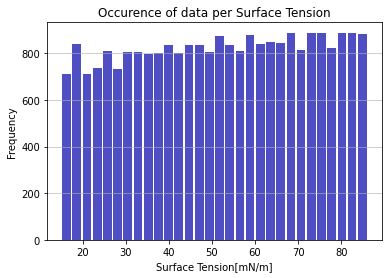

In [4]:
my_data_set_points = Droplet_data_set(data_matrix_points)
split_points = DataSplit(my_data_set_points, shuffle=True)  # Split the single dataset into 3 datasets for training, test and validation.
train_loader_points, val_loader_points, test_loader_points = split_points.get_split(batch_size=512, num_workers=0)

Create and splite the dataset for spline model

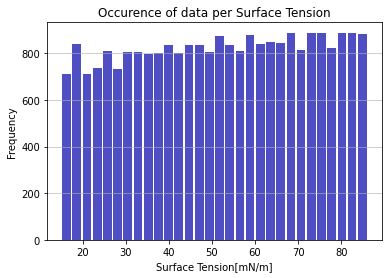

In [5]:
my_data_set_spline = Droplet_data_set(data_matrix_spline)
split_spline = DataSplit(my_data_set_spline, shuffle=True)  # Split the single dataset into 3 datasets for training, test and validation.
train_loader_spline, val_loader_spline, test_loader_spline = split_spline.get_split(batch_size=512, num_workers=0)

===========================================

### Load data for PictureNet
Read image from files

In [7]:
train_img = []
data_matrix_points = pd.read_csv("Data_uniform/Edge_points.csv", header= None)
data_matrix_spline = pd.read_csv("Data_uniform/Spline.csv", header= None)
data_image_points = data_matrix_points  
data_image_spline = data_matrix_spline

for img_name in data_image_points.iloc[0:,3:].index + 1:      # modify the number depends on size of dataset
    # defining the image path
    image_path = 'Data_uniform/' + str(img_name) + '.png'      # modify the path depends on which dataset
    # reading the image
    img = imread(image_path, as_gray=True)
    img = img[4:-4, 4:-4]  #crop 
    # normalizing the pixel values
    img /= 255.0
    # converting the type of pixel to float 32
    img = img.astype('float32')
    # appending the image into the list
    train_img.append(img)

Plot a single image for viewing

Current image = 3155
Picture size = (82, 77)


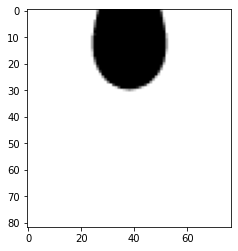

In [8]:
rand = random.randint(1, 24747)
print("Current image =", rand)
print("Picture size =", train_img[rand].shape)
plt.imshow(train_img[rand], cmap='gray')

Define the function

In [9]:
# Split and transfer the data from list to torch format
def split_n_transfer(x, y):
    # Points data split
    train_x_pic, rem_x_pic, train_y_pic, rem_y_pic = train_test_split(x, y, test_size = 0.2)    # default shuffle = True
    val_x_pic, test_x_pic, val_y_pic, test_y_pic = train_test_split(rem_x_pic, rem_y_pic, test_size = 0.5)

    # converting the train images of points and targets into torch format
    train_x_pic = train_x_pic.reshape(len(train_x_pic), 1, 82, 77)
    train_x_pic = torch.from_numpy(train_x_pic)
    train_y_pic = torch.from_numpy(train_y_pic)

    # converting the val images and target points into torch format
    val_x_pic = val_x_pic.reshape(len(val_x_pic), 1, 82, 77)
    val_x_pic = torch.from_numpy(val_x_pic)
    val_y_pic = torch.from_numpy(val_y_pic)
    # print(val_x_pic.shape, val_y_pic.shape)

    # converting the test images and targets into torch format for points
    test_x_pic = test_x_pic.reshape(len(test_x_pic), 1, 82, 77)
    test_x_pic  = torch.from_numpy(test_x_pic)
    test_y_pic = torch.from_numpy(test_y_pic)
    # print(test_x_pic.shape, test_y_pic.shape)
    
    return train_x_pic, train_y_pic, val_x_pic, val_y_pic, test_x_pic, test_y_pic

# converting the dataset into mini-batch dataset (input 4D -> 5D and 2D -> 3D)
def batch_transform(dataset, batch_size=512):
    batch = []
    batch_num = math.ceil(len(dataset)/batch_size)
    for i in range(batch_num):
        if len(dataset) == 4:
            if i < batch_num-1:
                batch.append(dataset[i*batch_size:(i+1)*batch_size, :, :, :])
            else:
                batch.append(dataset[i*batch_size:, :, :, :])
        else:
            if i < batch_num-1:
                batch.append(dataset[i*batch_size:(i+1)*batch_size, :])
            else:
                batch.append(dataset[i*batch_size:, :])
    return batch

# converting all raw datasets into batch datasets in the same time
def batch_all(train_x, train_y, val_x, val_y, test_x, test_y):
    train_x_pic = batch_transform(train_x)
    train_y_pic = batch_transform(train_y)
    val_x_pic = batch_transform(val_x)
    val_y_pic = batch_transform(val_y)
    test_x_pic = batch_transform(test_x)
    test_y_pic = batch_transform(test_y)
    return train_x_pic, train_y_pic, val_x_pic, val_y_pic, test_x_pic, test_y_pic

Create and splite the dataset for edge point model

In [10]:
# converting the list to numpy array
train_x_pic = np.array(train_img)
train_y_pic_points = data_image_points.iloc[0:,3:].values

train_x_pic_points, train_y_pic_points, val_x_pic_points, val_y_pic_points, test_x_pic_points, test_y_pic_points = \
    split_n_transfer(train_x_pic, train_y_pic_points)

train_x_pic_points, train_y_pic_points, val_x_pic_points, val_y_pic_points, test_x_pic_points, test_y_pic_points = \
    batch_all(train_x_pic_points, train_y_pic_points, val_x_pic_points, val_y_pic_points, test_x_pic_points, test_y_pic_points)
    
print(len(train_x_pic_points), len(train_y_pic_points), len(val_x_pic_points), len(val_y_pic_points), len(test_x_pic_points), len(test_y_pic_points))


39 39 5 5 5 5


Create and splite the dataset for spline model

In [11]:
# converting the list to numpy array
train_x_pic = np.array(train_img)
train_y_pic_spline = data_image_spline.iloc[0:,3:].values

train_x_pic_spline, train_y_pic_spline, val_x_pic_spline, val_y_pic_spline, test_x_pic_spline, test_y_pic_spline = \
    split_n_transfer(train_x_pic, train_y_pic_spline)

train_x_pic_spline, train_y_pic_spline, val_x_pic_spline, val_y_pic_spline, test_x_pic_spline, test_y_pic_spline = \
    batch_all(train_x_pic_spline, train_y_pic_spline, val_x_pic_spline, val_y_pic_spline, test_x_pic_spline, test_y_pic_spline)

print(len(train_x_pic_spline), len(train_y_pic_spline), len(val_x_pic_spline), len(val_y_pic_spline), len(test_x_pic_spline), len(test_y_pic_spline))

39 39 5 5 5 5


==============================

### Deside to apply host or device


In [12]:
USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cuda


## Define the functions for models

In [13]:
def loss_cal_phiysics(loss_list, model, loader):
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        loss_epoch = 0
        for t, (x, y) in enumerate(loader):
            x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float32)
            scores = model(x)
            loss = F.mse_loss(scores, y)
            loss_epoch += loss
        loss_list.append(loss_epoch.cpu().data.numpy()/t)

def loss_cal_picture(loss_list, model, x_dataset, y_dataset):
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        loss_epoch = 0
        for t in range(len(x_dataset)):
            x = x_dataset[t]
            y = y_dataset[t]
            x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float32)
            scores = model(x)
            loss = F.mse_loss(scores, y)
            loss_epoch += loss
        loss_list.append(loss_epoch.cpu().data.numpy()/t)

def prediction(model, x):   # only a batch
    model = model.to(device=device)
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        x = x.to(device=device, dtype=torch.float32)
        score = torch.Tensor.cpu(model(x))
    return score

def model_selection(model, path, loss, epoch_current, epoch_ref, loss_ref):
    loss_best = loss_ref
    epoch_best = epoch_ref
    if epoch_current == 0 and ~(os.path.isdir(path)):
            loss_current = loss[epoch_current]
            loss_best = loss[epoch_current]
            torch.save(model, path)
    else:
        loss_current = loss[epoch_current]
        if loss_current <= (loss_best * 1.1):   # 10% margin to get better fitting but a bit more loss
            loss_best = loss_current
            epoch_best = epoch_current
            torch.save(model, path)
    return loss_best, epoch_best

def train_physics(model, optimizer, epochs=1, model_input=0):
    loss_train = []
    loss_val = []
    loss_best = 0
    epoch_best = 0
    
    # model selection depends on data type
    if model_input == 0:
        train_loader = train_loader_points
        val_loader = val_loader_points
        PATH_CAL = os.path.join(os.getcwd(), "model_cal_points.pt")
    elif model_input == 1:
        train_loader = train_loader_spline
        val_loader = val_loader_spline
        PATH_CAL = os.path.join(os.getcwd(), "model_cal_spline.pt")
    else:
        ValueError("Incorrect input: 0 for edge point model, 1 for spline model")

    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for _, (x, y) in enumerate(train_loader):
            x = x.reshape(len(x), 1, 1, -1)     # reshape to 4D data for formal input of model
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float32)
            scores = model(x)
            loss = F.mse_loss(scores, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        loss_cal_phiysics(loss_train, model, train_loader)
        loss_cal_phiysics(loss_val, model, val_loader)
        print('epoch %d: train_loss = %.4f, val_loss = %.4f' % (e+1, loss_train[e], loss_val[e]))

        # selecting the best model to save
        loss_best, epoch_best = model_selection(model, PATH_CAL, loss_train, e, epoch_best, loss_best)
    
    print("The model is saved at epoch =", epoch_best+1, "and the loss =", loss_best.item())
    
    x = range(1, epochs+1)

    plt.semilogy(x, loss_train, 'b-', label="training loss")
    plt.semilogy(x, loss_val, 'r--', label="validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("MSE Loss")
    plt.title("Train/Validation Loss")
    plt.legend()
    plt.show()

def train_picture(model, optimizer, epochs=1, model_input=0):
    loss_train = []
    loss_val = []
    loss_best = 0
    epoch_best = 0

    # model selection depends on data type
    if model_input == 0:
        train_x_pic = train_x_pic_points
        train_y_pic = train_y_pic_points
        val_x_pic = val_x_pic_points
        val_y_pic = val_y_pic_points
        PATH_PIC = os.path.join(os.getcwd(), "model_pic_points.pt")
    elif model_input == 1:
        train_x_pic = train_x_pic_spline
        train_y_pic = train_y_pic_spline
        val_x_pic = val_x_pic_spline
        val_y_pic = val_y_pic_spline
        PATH_PIC = os.path.join(os.getcwd(), "model_pic_spline.pt")
    else:
        ValueError("Incorrect input: 0 for edge point model, 1 for spline model")

    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t in range(len(train_x_pic)):
            model.train()  # put model to training mode
            x = train_x_pic[t]
            y = train_y_pic[t]
            x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float32)

            scores = model(x)
            loss = F.mse_loss(scores, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        loss_cal_picture(loss_train, model, train_x_pic, train_y_pic)
        loss_cal_picture(loss_val, model, val_x_pic, val_y_pic)
        print('epoch %d: train_loss = %.4f, val_loss = %.4f' % (e+1, loss_train[e], loss_val[e]))
        
        # selecting the best model to save
        loss_best, epoch_best = model_selection(model, PATH_PIC, loss_train, e, epoch_best, loss_best)
    
    print("The model is saved at epoch =", epoch_best+1, "and the loss =", loss_best.item())

    x = range(1, epochs+1)

    plt.semilogy(x, loss_train, 'b-', label="training loss")
    plt.semilogy(x, loss_val, 'r--', label="validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("MSE Loss")
    plt.title("Train/Validation Loss")
    plt.legend()
    plt.show()


## Train PhysicsNet Edge Points

epoch 1: train_loss = 1756.4790, val_loss = 2243.4463
epoch 2: train_loss = 1675.4700, val_loss = 2140.3005
epoch 3: train_loss = 1675.5399, val_loss = 2135.0859
epoch 4: train_loss = 1599.3284, val_loss = 2039.1221
epoch 5: train_loss = 1518.1457, val_loss = 1936.9183
epoch 6: train_loss = 1425.2309, val_loss = 1816.8428
epoch 7: train_loss = 1500.0094, val_loss = 1915.8862
epoch 8: train_loss = 1417.8532, val_loss = 1806.8035
epoch 9: train_loss = 1369.4207, val_loss = 1748.2638
epoch 10: train_loss = 1261.1827, val_loss = 1608.0155
epoch 11: train_loss = 1202.9126, val_loss = 1533.3734
epoch 12: train_loss = 1209.3827, val_loss = 1539.1413
epoch 13: train_loss = 1022.8225, val_loss = 1303.5728
epoch 14: train_loss = 1123.7019, val_loss = 1430.2806
epoch 15: train_loss = 874.8691, val_loss = 1111.9181
epoch 16: train_loss = 916.9521, val_loss = 1168.9044
epoch 17: train_loss = 782.3069, val_loss = 992.4996
epoch 18: train_loss = 741.8175, val_loss = 944.6746
epoch 19: train_loss = 64

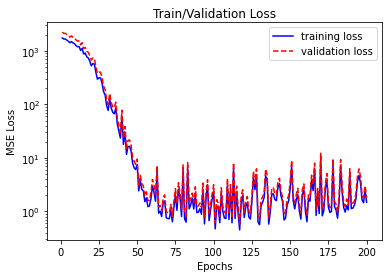

In [13]:
in_channel = 160
node_1 = 512
node_2 = 512
node_3 = 256
node_4 = 256
node_5 = 64
node_6 = 16
out_channel = 2

learning_rate = 1e-3

model_physics = PhysicsNet(in_channel, node_1, node_2, node_3, node_4, node_5, node_6, out_channel)
optimizer = optim.Adam(model_physics.parameters(), lr=learning_rate)
epoch = 200

# 0 indicates edge points 1 indicates spline
train_physics(model_physics, optimizer, epoch, 0)

## Train PhysicsNet spline

epoch 1: train_loss = 1798.8305, val_loss = 2305.5142
epoch 2: train_loss = 1752.4977, val_loss = 2242.7549
epoch 3: train_loss = 1681.7762, val_loss = 2151.7607
epoch 4: train_loss = 1639.8874, val_loss = 2097.3151
epoch 5: train_loss = 1632.4991, val_loss = 2090.2035
epoch 6: train_loss = 1580.9339, val_loss = 2021.5833
epoch 7: train_loss = 1517.9661, val_loss = 1941.6079
epoch 8: train_loss = 1467.7565, val_loss = 1875.4199
epoch 9: train_loss = 1371.7022, val_loss = 1752.6564
epoch 10: train_loss = 1296.8405, val_loss = 1659.8714
epoch 11: train_loss = 1085.5496, val_loss = 1388.5195
epoch 12: train_loss = 1197.3317, val_loss = 1531.1659
epoch 13: train_loss = 1074.8750, val_loss = 1374.3761
epoch 14: train_loss = 1010.4200, val_loss = 1294.2620
epoch 15: train_loss = 943.4420, val_loss = 1205.5658
epoch 16: train_loss = 842.7726, val_loss = 1077.5487
epoch 17: train_loss = 753.2667, val_loss = 962.1426
epoch 18: train_loss = 723.1134, val_loss = 924.8169
epoch 19: train_loss = 69

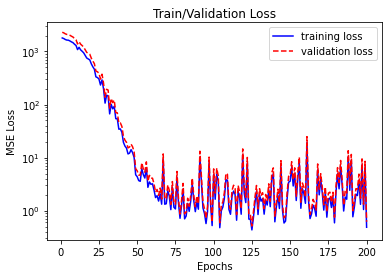

In [14]:
in_channel = 22
node_1 = 512
node_2 = 512
node_3 = 256
node_4 = 256
node_5 = 64
node_6 = 16
out_channel = 2

model_physics = PhysicsNet(in_channel, node_1, node_2, node_3, node_4, node_5, node_6, out_channel)
optimizer = optim.Adam(model_physics.parameters(), lr=learning_rate)
epoch = 200

# 0 indicates edge points 1 indicates spline
train_physics(model_physics, optimizer, epoch, 1)

<font color=red>
It seems like more points we have, small oscillation we get.<br>
Instead of taking the polynomial coefficients as input, transfer coefficients into points.
</font>

### Retrain with SGD

epoch 1: train_loss = 0.1965, val_loss = 0.2486
epoch 2: train_loss = 0.1950, val_loss = 0.2495
epoch 3: train_loss = 0.5170, val_loss = 0.6382
epoch 4: train_loss = 0.2383, val_loss = 0.3036
epoch 5: train_loss = 0.2153, val_loss = 0.2701
epoch 6: train_loss = 0.2214, val_loss = 0.2832
epoch 7: train_loss = 0.2099, val_loss = 0.2634
epoch 8: train_loss = 0.6380, val_loss = 0.7930
epoch 9: train_loss = 0.1976, val_loss = 0.2536
epoch 10: train_loss = 0.2522, val_loss = 0.3194
epoch 11: train_loss = 0.6812, val_loss = 0.8413
epoch 12: train_loss = 0.2381, val_loss = 0.3030
epoch 13: train_loss = 0.1849, val_loss = 0.2344
epoch 14: train_loss = 0.2116, val_loss = 0.2698
epoch 15: train_loss = 0.2094, val_loss = 0.2657
epoch 16: train_loss = 0.2304, val_loss = 0.2934
epoch 17: train_loss = 0.2164, val_loss = 0.2751
epoch 18: train_loss = 0.2657, val_loss = 0.3359
epoch 19: train_loss = 0.3783, val_loss = 0.4643
epoch 20: train_loss = 0.2140, val_loss = 0.2769
epoch 21: train_loss = 0.3812

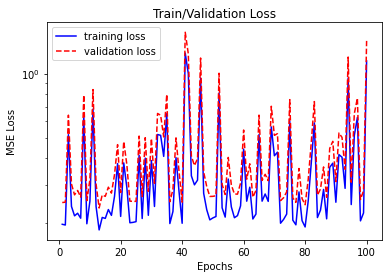

In [18]:
# PATH_CAL = os.path.join(os.getcwd(), "model_cal_points.pt")
PATH_CAL = os.path.join(os.getcwd(), "model_cal_spline.pt")

model_physics_trained = torch.load(PATH_CAL)

learning_rate = 1e-4

optimizer = optim.SGD(model_physics_trained.parameters(), lr=learning_rate)
epoch = 100

# 0 indicates edge points 1 indicates spline
train_physics(model_physics_trained, optimizer, epoch, 1)

### Visualization of outcomes
Edge Point Model

In [19]:
PATH_CAL_POINTS = os.path.join(os.getcwd(), "model_cal_points.pt")

model_physics_trained_points = torch.load(PATH_CAL_POINTS)

examples = enumerate(test_loader_points)
_, (x_test_points, y_test_points) = next(examples)

score_example_points = prediction(model_physics_trained_points, x_test_points)

# Print only 8 data samples for comparison
print("Ground Truths     =", y_test_points[:8])
print("Prediction Points =", score_example_points[:8].reshape(8, 2))

Ground Truths     = tensor([[54.8000, 22.4818],
        [48.4000, 18.0608],
        [34.1000, 10.4128],
        [58.1000, 19.5164],
        [15.2000,  6.0122],
        [23.5000, 10.1629],
        [49.2000, 23.5172],
        [60.0000, 26.3465]])
Prediction Points = tensor([[55.0641, 22.5130],
        [48.1196, 18.0145],
        [34.7935, 10.6914],
        [58.1139, 19.6032],
        [17.1270,  7.0388],
        [23.4197, 10.2470],
        [48.8733, 23.6151],
        [59.3774, 26.5298]])


Spline Model

In [20]:
PATH_CAL_SPLINE = os.path.join(os.getcwd(), "model_cal_spline.pt")

model_physics_trained_spline = torch.load(PATH_CAL_SPLINE)

examples = enumerate(test_loader_spline)
_, (x_test_spline, y_test_spline) = next(examples)

score_example_spline = prediction(model_physics_trained_spline, x_test_spline)

# Print only 8 data samples for comparison
print("Ground Truths     =", y_test_spline[:8])
print("Prediction Spline =", score_example_spline[:8].reshape(8, 2))

Ground Truths     = tensor([[68.7000, 18.6822],
        [30.9000, 14.0615],
        [17.6000,  6.9696],
        [41.2000, 18.7705],
        [73.4000, 31.9182],
        [44.2000, 15.5686],
        [49.1000, 23.1726],
        [64.6000, 24.3229]])
Prediction Spline = tensor([[68.2813, 19.1397],
        [31.0530, 14.0957],
        [17.9066,  7.0499],
        [41.3635, 18.7978],
        [73.2092, 32.2094],
        [44.5009, 15.4835],
        [49.3956, 22.9681],
        [64.1972, 24.1634]])


## Train PictureNet edge points

epoch 1: train_loss = 1.0819, val_loss = 1.3115
epoch 2: train_loss = 1.0549, val_loss = 1.2768
epoch 3: train_loss = 0.0295, val_loss = 0.0357
epoch 4: train_loss = 0.7713, val_loss = 0.9387
epoch 5: train_loss = 0.2277, val_loss = 0.2777
epoch 6: train_loss = 0.0100, val_loss = 0.0121
epoch 7: train_loss = 1.5768, val_loss = 1.9165
epoch 8: train_loss = 0.0600, val_loss = 0.0728
epoch 9: train_loss = 1.3030, val_loss = 1.5843
epoch 10: train_loss = 0.3826, val_loss = 0.4661
epoch 11: train_loss = 0.2732, val_loss = 0.3321
epoch 12: train_loss = 0.0085, val_loss = 0.0104
epoch 13: train_loss = 0.7909, val_loss = 0.9631
epoch 14: train_loss = 0.1190, val_loss = 0.1449
epoch 15: train_loss = 1.2889, val_loss = 1.5679
epoch 16: train_loss = 1.1996, val_loss = 1.4562
epoch 17: train_loss = 0.0009, val_loss = 0.0010
epoch 18: train_loss = 1.5206, val_loss = 1.8451
epoch 19: train_loss = 1.6373, val_loss = 1.9875
epoch 20: train_loss = 1.2104, val_loss = 1.4709
epoch 21: train_loss = 1.1782

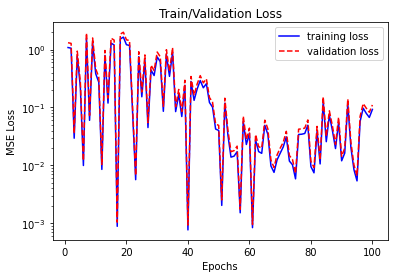

In [21]:
in_channel = 1
channel_1 = 16
channel_2 = 32
channel_3 = 64
node_1 = 1024
node_2 = 1024
out_channel = 160

learning_rate = 1e-3

model_picture = PictureNet(in_channel, channel_1, channel_2, channel_3, node_1, node_2, out_channel)
optimizer = optim.Adam(model_picture.parameters(), lr=learning_rate)
epoch = 100

# 0 indicates edge points 1 indicates spline
train_picture(model_picture, optimizer, epoch, 0)

## Train PictureNet for spline

epoch 1: train_loss = 1.0596, val_loss = 1.2897
epoch 2: train_loss = 0.6276, val_loss = 0.7643
epoch 3: train_loss = 0.0253, val_loss = 0.0308
epoch 4: train_loss = 0.0067, val_loss = 0.0082
epoch 5: train_loss = 0.0065, val_loss = 0.0079
epoch 6: train_loss = 0.0035, val_loss = 0.0042
epoch 7: train_loss = 0.0037, val_loss = 0.0045
epoch 8: train_loss = 0.0036, val_loss = 0.0044
epoch 9: train_loss = 0.0009, val_loss = 0.0010
epoch 10: train_loss = 0.0021, val_loss = 0.0025
epoch 11: train_loss = 0.0022, val_loss = 0.0027
epoch 12: train_loss = 0.0033, val_loss = 0.0040
epoch 13: train_loss = 0.0014, val_loss = 0.0016
epoch 14: train_loss = 0.0016, val_loss = 0.0020
epoch 15: train_loss = 0.0064, val_loss = 0.0078
epoch 16: train_loss = 0.0064, val_loss = 0.0078
epoch 17: train_loss = 0.0013, val_loss = 0.0016
epoch 18: train_loss = 0.0171, val_loss = 0.0208
epoch 19: train_loss = 0.0045, val_loss = 0.0054
epoch 20: train_loss = 0.0009, val_loss = 0.0011
epoch 21: train_loss = 0.0286

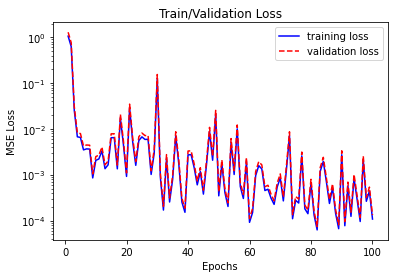

In [22]:
in_channel = 1
channel_1 = 16
channel_2 = 32
channel_3 = 64
node_1 = 1024
node_2 = 1024
out_channel = 22

learning_rate = 1e-3

model_picture = PictureNet(in_channel, channel_1, channel_2, channel_3, node_1, node_2, out_channel)
optimizer = optim.Adam(model_picture.parameters(), lr=learning_rate)
epoch = 100

# 0 indicates edge points 1 indicates spline
train_picture(model_picture, optimizer, epoch, 1)

### Retrain with SGD

epoch 1: train_loss = 0.0003, val_loss = 0.0003
epoch 2: train_loss = 0.0001, val_loss = 0.0002
epoch 3: train_loss = 0.0001, val_loss = 0.0001
epoch 4: train_loss = 0.0001, val_loss = 0.0001
epoch 5: train_loss = 0.0001, val_loss = 0.0002
epoch 6: train_loss = 0.0001, val_loss = 0.0002
epoch 7: train_loss = 0.0001, val_loss = 0.0002
epoch 8: train_loss = 0.0001, val_loss = 0.0002
epoch 9: train_loss = 0.0001, val_loss = 0.0002
epoch 10: train_loss = 0.0001, val_loss = 0.0002
epoch 11: train_loss = 0.0001, val_loss = 0.0002
epoch 12: train_loss = 0.0001, val_loss = 0.0002
epoch 13: train_loss = 0.0001, val_loss = 0.0002
epoch 14: train_loss = 0.0001, val_loss = 0.0002
epoch 15: train_loss = 0.0001, val_loss = 0.0002
epoch 16: train_loss = 0.0001, val_loss = 0.0002
epoch 17: train_loss = 0.0001, val_loss = 0.0001
epoch 18: train_loss = 0.0001, val_loss = 0.0002
epoch 19: train_loss = 0.0001, val_loss = 0.0002
epoch 20: train_loss = 0.0001, val_loss = 0.0002
The model is saved at epoch =

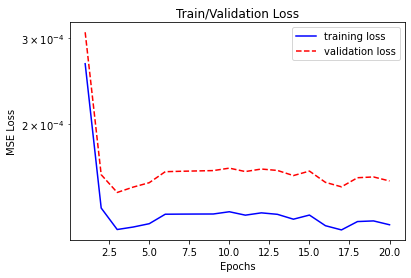

In [28]:
PATH_PIC = os.path.join(os.getcwd(), "model_pic_points.pt")
# PATH_PIC = os.path.join(os.getcwd(), "model_pic_spline.pt")

model_picture_trained = torch.load(PATH_PIC)

learning_rate = 1e-3

optimizer = optim.SGD(model_picture_trained.parameters(), lr=learning_rate)
epoch = 20

# 0 indicates edge points 1 indicates spline
train_picture(model_picture_trained, optimizer, epoch, 0)

### Visualization of outcomes

In [29]:
# testing cell for better viewing the length
train_x_pic_points, train_y_pic_points

print(len(train_x_pic_points))
print(train_x_pic_points[0].shape)
print(train_y_pic_points[0].shape)

39
torch.Size([512, 1, 82, 77])
torch.Size([512, 160])


Edge Point Model

In [42]:
PATH_PIC = os.path.join(os.getcwd(), "model_pic_points.pt")
model_picture_trained = torch.load(PATH_PIC)

rand1 = random.randint(0, len(test_x_pic_points)-1)
rand2 = random.randint(0, 511)

print("current batch =", rand1)
print("current testing image =", rand2)

score_pic = prediction(model_picture_trained, test_x_pic_points[rand1][rand2].reshape(1, 1, 82, 77))

# Print all points out for viewing
# for num in range(len(test_y_pic_points[rand1][rand2])):
#     print(num+1, ": Ground Truths =", test_y_pic_points[rand1][rand2][num].item(), ", Prediction =", score_pic[0, num].item())


current batch = 3
current testing image = 497


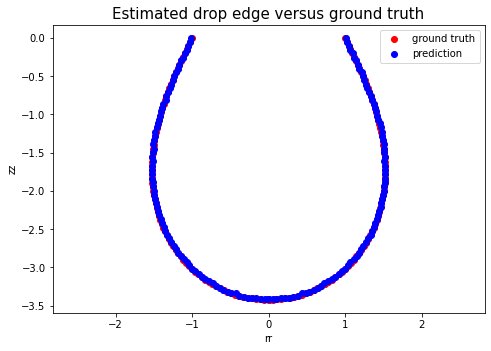

In [43]:
# scattering points for ground truth
x_gt_pos = test_y_pic_points[rand1][rand2][0:80]
y_gt_pos = test_y_pic_points[rand1][rand2][80:160]
x_gt_neg = -torch.flip(x_gt_pos, [0])
y_gt_neg = torch.flip(y_gt_pos, [0])
x_gt = torch.cat((x_gt_neg, x_gt_pos))
y_gt = torch.cat((y_gt_neg, y_gt_pos))

# scattering points for prediction
x_pred_pos = score_pic[0, 0:80]
y_pred_pos = score_pic[0, 80:160]
x_pred_neg = -torch.flip(x_pred_pos, [0])
y_pred_neg = torch.flip(y_pred_pos, [0])
x_pred = torch.cat((x_pred_neg, x_pred_pos))
y_pred = torch.cat((y_pred_neg, y_pred_pos))

# plotting
fig = plt.figure()
a1 = fig.add_axes([0,0,1,1])
a1.set_xlim(0,3)
a1.set_title("Estimated drop edge versus ground truth", fontsize = 15)
plt.scatter(x_gt, y_gt, c="red", label="ground truth")
plt.scatter(x_pred, y_pred, c="blue", label="prediction")
plt.xlabel("rr")
plt.ylabel("zz")
plt.legend()
plt.axis('equal')
plt.show()

Spline Model Interpolation points

In [44]:
#Number of interpolation points to use for PhysicsNet and plotting
Num_points = 160

In [45]:
#Load YC matrix for point values and s data for interpolation
data_YC = pd.read_csv("Data_uniform/YC.csv", header= None)
data_s = pd.read_csv("Data_uniform/s.csv", header= None)

YC = torch.Tensor(data_YC.values)
s = data_s.values
s = s.reshape(1,len(s))
#Interpolate to 160 points using a linear vector for s
ss = np.linspace(s[0][0],s[0][-1],Num_points)

Plot difference Spline and ground truth

In [46]:
PATH_PIC = os.path.join(os.getcwd(), "model_pic_spline.pt")
model_picture_trained = torch.load(PATH_PIC)

rand1 = random.randint(0, len(test_x_pic_spline)-1)
rand2 = random.randint(0, 30)

print("current batch =", rand1)
print("current testing image =", rand2)

score_pic_pred = prediction(model_picture_trained, test_x_pic_spline[rand1][rand2].reshape(1, 1, 82, 77))

#Multiply the found Chebyshev coefficients with YC matrix to obtain edge points
score_pic_r = torch.matmul(YC ,score_pic_pred[0, 0:11]) 
score_pic_z = torch.matmul(YC ,score_pic_pred[0, 11:22])

#Do polynominal fitting through data to get more data points
score_pic_r = np.polyval( np.polyfit(s[0],score_pic_r.numpy(),15), ss)
score_pic_z = np.polyval( np.polyfit(s[0],score_pic_z.numpy(),15), ss)

#Convert back to torch
score_pic_r = torch.tensor(score_pic_r)
score_pic_z = torch.tensor(score_pic_z)


test_y_pic_r = torch.matmul(YC ,test_y_pic_spline[rand1][rand2][0:11].float()) 
test_y_pic_z = torch.matmul(YC ,test_y_pic_spline[rand1][rand2][11:22].float()) 

#Do polynominal fitting through data to get more data points
test_y_pic_r = np.polyval( np.polyfit(s[0],test_y_pic_r.numpy(),15), ss)
test_y_pic_z = np.polyval( np.polyfit(s[0],test_y_pic_z.numpy(),15), ss)

#Convert back to torch
test_y_pic_r = torch.tensor(test_y_pic_r)
test_y_pic_z = torch.tensor(test_y_pic_z)

# Print all points out for viewing
# for num in range(len(test_y_pic_r)):
#    print(num+1, ": Ground Truths =", test_y_pic_z[num].item(), ", Prediction =", score_pic_z[num].item())


current batch = 0
current testing image = 3


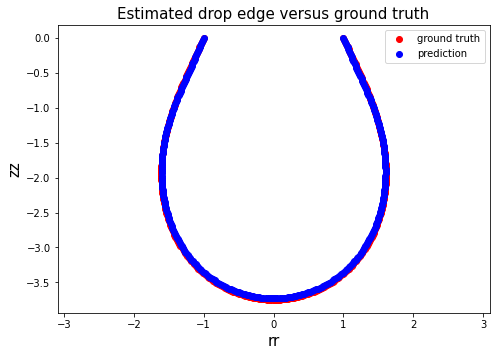

In [47]:
# scattering points for ground truth
gt_r_pos = test_y_pic_r
gt_r_neg = -torch.flip(test_y_pic_r, [0])
gt_z_pos = test_y_pic_z
gt_z_neg = torch.flip(test_y_pic_z, [0])
gt_r = torch.cat((gt_r_neg, gt_r_pos))
gt_z = torch.cat((gt_z_neg, gt_z_pos))

# scattering points for prediction
pred_r_pos = score_pic_r
pred_r_neg = -torch.flip(score_pic_r, [0])
pred_z_pos = score_pic_z
pred_z_neg = torch.flip(score_pic_z, [0])
pred_r = torch.cat((pred_r_neg, pred_r_pos))
pred_z = torch.cat((pred_z_neg, pred_z_pos))

# plotting
fig = plt.figure()
a1 = fig.add_axes([0,0,1,1])
a1.set_xlim(0,3)
a1.set_title("Estimated drop edge versus ground truth", fontsize = 15)
plt.scatter(gt_r, gt_z, c="red", label="ground truth")
plt.scatter(pred_r, pred_z, c="blue", label="prediction")

plt.xlabel("rr",fontsize = 15)
plt.ylabel("zz",fontsize = 15)
plt.legend()
plt.axis('equal')
plt.show()

### Evaluation between two model predictions

In [48]:
# Edge Points -> x_gt, y_gt, x_pred, y_pred
# Spline -> gt_r, gt_z, pred_r, pred_z

l2_x_points = torch.sum(torch.pow((x_gt - x_pred), 2))
l2_y_points = torch.sum(torch.pow((y_gt - y_pred), 2))
l2_points = (l2_x_points + l2_y_points) / len(x_gt)
print("L2 norm of point =", l2_points.item())

l2_x_spline = torch.sum(torch.pow((gt_r - pred_r), 2))
l2_y_spline = torch.sum(torch.pow((gt_z - pred_z), 2))
l2_spline = (l2_x_spline + l2_y_spline) / len(gt_r)
print("L2 norm of spline =", l2_spline.item())

L2 norm of point = 6.339578671168537e-05
L2 norm of spline = 0.00019706918068968215
